In [1]:
from pydrake.all import FindResourceOrThrow, StartMeshcat, MeshcatVisualizer
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7001


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import time
from pydrake.math import RigidTransform
import pydot
from IPython.display import SVG, display


from pydrake.all import (
    DiagramBuilder, Simulator, FindResourceOrThrow, MultibodyPlant, PiecewisePolynomial, SceneGraph,
    Parser, MultibodyPositionToGeometryPose, TrajectorySource, Demultiplexer, ConstantVectorSource,
    AddMultibodyPlantSceneGraph, HalfSpace, CoulombFriction
)


def vis(x_traj, tf, time_step=0.01):
    # Create a MultibodyPlant for the arm
    file_name = "planar_walker.urdf"
    builder = DiagramBuilder()
    scene_graph = builder.AddSystem(SceneGraph())
    plant = MultibodyPlant(0.0)
    plant.RegisterAsSourceForSceneGraph(scene_graph)
    Parser(plant=plant).AddModels(file_name)

    plant.WeldFrames(
                plant.world_frame(),
                plant.GetBodyByName("base").body_frame(),
                RigidTransform.Identity()
            )

    plant.Finalize()

    n_q = plant.num_positions()
    n_v = plant.num_velocities()
    n_u = plant.num_actuators()

    x_traj_source = builder.AddSystem(TrajectorySource(x_traj))
    # u_traj_source = builder.AddSystem(TrajectorySource(u_traj))

    demux = builder.AddSystem(Demultiplexer(np.array([n_q, n_v])))
    to_pose = builder.AddSystem(MultibodyPositionToGeometryPose(plant))
    # zero_inputs = builder.AddSystem(ConstantVectorSource(np.zeros(n_u)))

    # builder.Connect(zero_inputs.get_output_port(), plant.get_actuation_input_port())
    builder.Connect(x_traj_source.get_output_port(), demux.get_input_port())
    builder.Connect(demux.get_output_port(0), to_pose.get_input_port())
    builder.Connect(to_pose.get_output_port(), scene_graph.get_source_pose_port(plant.get_source_id()))
    # builder.Connect(scene_graph.get_query_output_port(), plant.get_geometry_query_input_port())


    MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

    diagram = builder.Build()
    diagram.set_name("diagram")

    #display(SVG(pydot.graph_from_dot_data(
    #    diagram.GetGraphvizString(max_depth=2))[0].create_svg()))


    # Visualize the motion for `n_playback` times
    # n_playback = 3
    # for i in range(n_playback):
    #   # Set up a simulator to run this diagram.
    simulator = Simulator(diagram)
    simulator.Initialize()
    simulator.set_target_realtime_rate(time_step)
    simulator.AdvanceTo(tf);

## Swing Leg

In [13]:
import importlib
import traj_optim
import fsm_utils

importlib.reload(traj_optim)
importlib.reload(fsm_utils)
from traj_optim import TrajectoryOptimizationSolution, read_csv
from fsm_utils import (
    LEFT_STANCE, RIGHT_STANCE, SPACE_STANCE, DOUBLE_SUPPORT
)

# Walking

# Blue is Right feet, Red is left

solver = TrajectoryOptimizationSolution(n_foot=3)
N = 10
mode_seqs = [RIGHT_STANCE] #, LEFT_STANCE, RIGHT_STANCE]
repeat = 1
initial_states = read_csv("q&v.csv", N * repeat * len(mode_seqs))
tf = 0.5 # just now is tf = 2
destination = 0.3

x_traj, u_traj, prog = solver.solve(N, 
                                    mode_seqs, 
                                    repeat, 
                                    initial_states,
                                     mu=1, 
                                     tf=tf, 
                                     destination=destination, 
                                     iters=2e4,
                                     test=True)

Whole x shape:  (1, 10, 14)
Timesteps:  [0.001      0.05644444 0.11188889 0.16733333 0.22277778 0.27822222
 0.33366667 0.38911111 0.44455556 0.5       ]
Testing Mode, Keep the biped standing. Swing left legs backwards
mu = 1
Testing  20000.0  iterations
Time taken: 62.127910542010795 seconds
Check whether the friction cone constraint holds?
Check contact point velocity and acceleration be 0
Contact point velocity and acceleration be 0 Not Hold
h_m0_6: [<AutoDiffXd -1.7304212091007187e-09 nderiv=0> <AutoDiffXd 0.0 nderiv=0>
 <AutoDiffXd -6.228550453180048e-09 nderiv=0>
 <AutoDiffXd -0.0001082989425917353 nderiv=0> <AutoDiffXd 0.0 nderiv=0>
 <AutoDiffXd 0.00010249256282353694 nderiv=0>]
Check collocation constraints
Collocation constraints Not Hold
h_m0_2: [<AutoDiffXd -9.50836115398701e-09 nderiv=0>
 <AutoDiffXd 6.81278548853026e-09 nderiv=0>
 <AutoDiffXd -1.4352187993615928e-08 nderiv=0>
 <AutoDiffXd -9.848200743789448e-08 nderiv=0>
 <AutoDiffXd -8.878728463557195e-08 nderiv=0>
 <AutoD

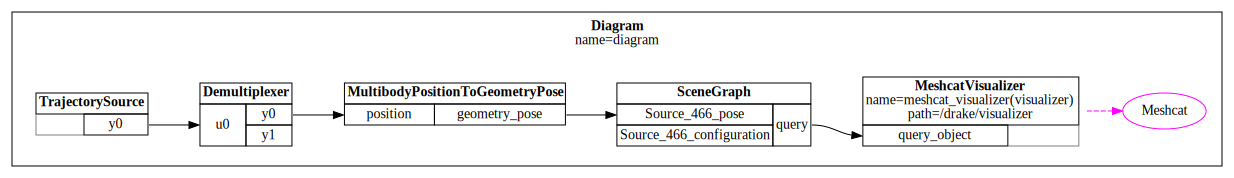

In [14]:
vis(x_traj, tf)

## Walking

In [46]:
%tb

import importlib
import traj_optim
import fsm_utils

importlib.reload(traj_optim)
importlib.reload(fsm_utils)
from traj_optim import TrajectoryOptimizationSolution, read_csv
from fsm_utils import (
    LEFT_STANCE, RIGHT_STANCE, SPACE_STANCE, DOUBLE_SUPPORT
)


solver = TrajectoryOptimizationSolution(n_foot=3)
N = 4
mode_seqs = [LEFT_STANCE, RIGHT_STANCE] #, LEFT_STANCE, RIGHT_STANCE]
repeat = 8
n_mode = len(mode_seqs)
#initial_states = read_csv("q&v.csv", N * repeat * len(mode_seqs))
xl = np.array(
        [-1.42628695e-01, 7.91008947e-01, -1.42999388e-01,
          -7.89749727e-01, 1.31650877e+00, -2.43590062e-01, 1.04394874e+00, 
          0, 0, 0, 
          0, 0, 0, 0]
      )
xr = np.array(
          [-1.42628695e-01, 7.91008947e-01, -1.42999388e-01,
         -2.43590062e-01, 1.04394874e+00,  -7.89749727e-01, 1.31650877e+00, 
          0, 0, 0, 
          0, 0, 0, 0]
)

initial_guesses = np.concatenate([xl if (i // N) % n_mode == 0 else xr 
                                  for i in range(n_mode * N * repeat)]).reshape(n_mode * N * repeat, 14)
initial_guesses[:, 0] = np.linspace(xl[0], destination, n_mode * N * repeat)
tf = 1.2 # just now is tf = 2
destination = 2.0

x_traj, u_traj, prog = solver.solve(N, 
                                    mode_seqs, 
                                    repeat, 
                                    initial_guesses,
                                     mu=1, 
                                     tf=tf, 
                                     destination=destination, 
                                     iters=16e4,
                                     test=False)

KeyboardInterrupt: 

Whole x shape:  (16, 4, 14)
Timesteps:  [1.00000000e-03 2.56666667e-02 5.03333333e-02 7.50000000e-02
 7.60000000e-02 1.00666667e-01 1.25333333e-01 1.50000000e-01
 1.51000000e-01 1.75666667e-01 2.00333333e-01 2.25000000e-01
 2.26000000e-01 2.50666667e-01 2.75333333e-01 3.00000000e-01
 3.01000000e-01 3.25666667e-01 3.50333333e-01 3.75000000e-01
 3.76000000e-01 4.00666667e-01 4.25333333e-01 4.50000000e-01
 4.51000000e-01 4.75666667e-01 5.00333333e-01 5.25000000e-01
 5.26000000e-01 5.50666667e-01 5.75333333e-01 6.00000000e-01
 6.01000000e-01 6.25666667e-01 6.50333333e-01 6.75000000e-01
 6.76000000e-01 7.00666667e-01 7.25333333e-01 7.50000000e-01
 7.51000000e-01 7.75666667e-01 8.00333333e-01 8.25000000e-01
 8.26000000e-01 8.50666667e-01 8.75333333e-01 9.00000000e-01
 9.01000000e-01 9.25666667e-01 9.50333333e-01 9.75000000e-01
 9.76000000e-01 1.00066667e+00 1.02533333e+00 1.05000000e+00
 1.05100000e+00 1.07566667e+00 1.10033333e+00 1.12500000e+00
 1.12600000e+00 1.15066667e+00 1.17533333e+00

In [47]:
vis(x_traj, tf, 0.1)

## Hopping

In [21]:
%tb

import importlib
import traj_optim
import fsm_utils

importlib.reload(traj_optim)
importlib.reload(fsm_utils)
from traj_optim import TrajectoryOptimizationSolution, read_csv
from fsm_utils import (
    LEFT_STANCE, RIGHT_STANCE, SPACE_STANCE, DOUBLE_SUPPORT
)


solver = TrajectoryOptimizationSolution(n_foot=6)
N = 4
mode_seqs = [RIGHT_STANCE, SPACE_STANCE] #, LEFT_STANCE, RIGHT_STANCE]
repeat = 2
initial_states = read_csv("q&v.csv", N * repeat * len(mode_seqs))
tf = 0.8 # just now is tf = 2
destination = 1.2

x_traj, u_traj, prog = solver.solve(N, 
                                    mode_seqs, 
                                    repeat, 
                                    initial_states,
                                     mu=1, 
                                     tf=tf, 
                                     destination=destination, 
                                     iters=5e4,
                                     test=False)

RuntimeError: Exception while evaluating SNOPT costs and constraints: 'KeyboardInterrupt: <EMPTY MESSAGE>

At:
  /Users/mac/Desktop/PENN/meam517/2DBiped/traj_optim.py(148): CalculateContactJacobian
  /Users/mac/Desktop/PENN/meam517/2DBiped/traj_optim.py(215): CollocationConstraintEvaluator
  /Users/mac/Desktop/PENN/meam517/2DBiped/traj_optim.py(244): CollocationConstraintHelper
  /Users/mac/Desktop/PENN/meam517/2DBiped/traj_optim.py(635): solve
  /var/folders/2b/f05brwcd04j_z8kby3z17scw0000gn/T/ipykernel_8930/569044620.py(23): <module>
  /Users/mac/Desktop/PENN/meam517/2DBiped/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py(3550): run_code
  /Users/mac/Desktop/PENN/meam517/2DBiped/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py(3490): run_ast_nodes
  /Users/mac/Desktop/PENN/meam517/2DBiped/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py(3308): run_cell_async
  /Users/mac/Desktop/PENN/meam517/2DBiped/.venv/lib/python3.11/site-packages/IPython/core/async_helpers.py(129): _pseudo_sync_runner
  /Users/mac/Desktop/PENN/meam517/2DBiped/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py(3103): _run_cell
  /Users/mac/Desktop/PENN/meam517/2DBiped/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py(3048): run_cell
  /Users/mac/Desktop/PENN/meam517/2DBiped/.venv/lib/python3.11/site-packages/ipykernel/zmqshell.py(549): run_cell
  /Users/mac/Desktop/PENN/meam517/2DBiped/.venv/lib/python3.11/site-packages/ipykernel/ipkernel.py(429): do_execute
  /Users/mac/Desktop/PENN/meam517/2DBiped/.venv/lib/python3.11/site-packages/ipykernel/kernelbase.py(766): execute_request
  /Users/mac/Desktop/PENN/meam517/2DBiped/.venv/lib/python3.11/site-packages/ipykernel/kernelbase.py(424): dispatch_shell
  /Users/mac/Desktop/PENN/meam517/2DBiped/.venv/lib/python3.11/site-packages/ipykernel/kernelbase.py(518): process_one
  /Users/mac/Desktop/PENN/meam517/2DBiped/.venv/lib/python3.11/site-packages/ipykernel/kernelbase.py(529): dispatch_queue
  /opt/homebrew/Cellar/python@3.11/3.11.6_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/events.py(80): _run
  /opt/homebrew/Cellar/python@3.11/3.11.6_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/base_events.py(1922): _run_once
  /opt/homebrew/Cellar/python@3.11/3.11.6_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/base_events.py(607): run_forever
  /Users/mac/Desktop/PENN/meam517/2DBiped/.venv/lib/python3.11/site-packages/tornado/platform/asyncio.py(205): start
  /Users/mac/Desktop/PENN/meam517/2DBiped/.venv/lib/python3.11/site-packages/ipykernel/kernelapp.py(739): start
  /Users/mac/Desktop/PENN/meam517/2DBiped/.venv/lib/python3.11/site-packages/traitlets/config/application.py(1077): launch_instance
  /Users/mac/Desktop/PENN/meam517/2DBiped/.venv/lib/python3.11/site-packages/ipykernel_launcher.py(17): <module>
  <frozen runpy>(88): _run_code
  <frozen runpy>(198): _run_module_as_main
'

Whole x shape:  (4, 4, 14)
Timesteps:  [0.001      0.06733333 0.13366667 0.2        0.201      0.26733333
 0.33366667 0.4        0.401      0.46733333 0.53366667 0.6
 0.601      0.66733333 0.73366667 0.8       ]
Destination: 1.2m
mu = 1
Testing  50000.0  iterations
Time taken: 25.31296566600213 seconds
Check whether the friction cone constraint holds?
Check contact point velocity and acceleration be 0
Check collocation constraints
optimal cost:  0.06790387265710265
x_sol:  [[[-6.15905238e-14  8.00000000e-01  9.50171102e-14 -6.43501110e-01
    1.28700222e+00 -6.43501110e-01  1.28700222e+00  2.66817200e-13
    2.84478594e-14  7.35659094e-14 -5.37139615e-14  2.06256423e-13
   -3.58426443e-15  0.00000000e+00]
  [-1.56809270e-04  7.78153710e-01 -2.87460091e-04 -6.58950375e-01
    1.36939313e+00 -6.79602607e-01  1.35815092e+00 -4.71588180e-03
   -6.58857467e-01 -8.30354010e-03 -4.23731906e-01  2.32762757e+00
   -1.06357773e+00  2.09802179e+00]
  [-5.17314341e-04  7.12648934e-01 -9.46847641e-

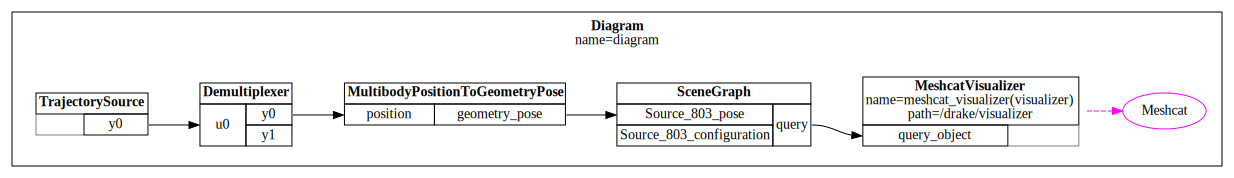

KeyboardInterrupt: 

In [ ]:
vis(x_traj, tf)

## Jumping

In [8]:
%tb

import importlib
import traj_optim
import fsm_utils

importlib.reload(traj_optim)
importlib.reload(fsm_utils)
from traj_optim import TrajectoryOptimizationSolution, read_csv
from fsm_utils import (
    LEFT_STANCE, RIGHT_STANCE, SPACE_STANCE, DOUBLE_SUPPORT
)


solver = TrajectoryOptimizationSolution(n_foot=6)
N = 4
mode_seqs = [DOUBLE_SUPPORT, SPACE_STANCE] #, LEFT_STANCE, RIGHT_STANCE]
repeat = 2
n_mode = len(mode_seqs)
#initial_states = read_csv("q&v.csv", N * repeat * len(mode_seqs))
initial_state = np.array(
        [-1.42628695e-01, 7.91008947e-01, -1.42999388e-01,
          -7.89749727e-01, 1.31650877e+00, -2.43590062e-01,
          1.04394874e+00, 5.19363218e-03, -1.95243469e+00,
          7.79505381e-03, -1.02836908e+00, 2.33236579e-01,
          2.07434133e+00, -4.95476373e+00]
      )
initial_guesses = np.concatenate([initial_state for _ in range(n_mode * N * repeat)]).reshape(n_mode * N * repeat, 14)
initial_guesses[:, 0] = np.linspace(initial_state[0], destination, n_mode * N * repeat)

tf = 0.8 # just now is tf = 2
destination = 1.6

x_traj_jump, u_traj, prog = solver.solve(N, 
                                    mode_seqs, 
                                    repeat, 
                                    initial_guesses,
                                     mu=1, 
                                     tf=tf, 
                                     destination=destination, 
                                     iters=5e4,
                                     test=False)

RuntimeError: Exception while evaluating SNOPT costs and constraints: 'KeyboardInterrupt: <EMPTY MESSAGE>

At:
  /Users/mac/Desktop/PENN/meam517/2DBiped/traj_optim.py(196): EvaluateDynamics
  /Users/mac/Desktop/PENN/meam517/2DBiped/traj_optim.py(219): CollocationConstraintEvaluator
  /Users/mac/Desktop/PENN/meam517/2DBiped/traj_optim.py(244): CollocationConstraintHelper
  /Users/mac/Desktop/PENN/meam517/2DBiped/traj_optim.py(651): solve
  /var/folders/2b/f05brwcd04j_z8kby3z17scw0000gn/T/ipykernel_25412/184970104.py(23): <module>
  /Users/mac/Desktop/PENN/meam517/2DBiped/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py(3550): run_code
  /Users/mac/Desktop/PENN/meam517/2DBiped/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py(3490): run_ast_nodes
  /Users/mac/Desktop/PENN/meam517/2DBiped/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py(3308): run_cell_async
  /Users/mac/Desktop/PENN/meam517/2DBiped/.venv/lib/python3.11/site-packages/IPython/core/async_helpers.py(129): _pseudo_sync_runner
  /Users/mac/Desktop/PENN/meam517/2DBiped/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py(3103): _run_cell
  /Users/mac/Desktop/PENN/meam517/2DBiped/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py(3048): run_cell
  /Users/mac/Desktop/PENN/meam517/2DBiped/.venv/lib/python3.11/site-packages/ipykernel/zmqshell.py(549): run_cell
  /Users/mac/Desktop/PENN/meam517/2DBiped/.venv/lib/python3.11/site-packages/ipykernel/ipkernel.py(429): do_execute
  /Users/mac/Desktop/PENN/meam517/2DBiped/.venv/lib/python3.11/site-packages/ipykernel/kernelbase.py(766): execute_request
  /Users/mac/Desktop/PENN/meam517/2DBiped/.venv/lib/python3.11/site-packages/ipykernel/kernelbase.py(424): dispatch_shell
  /Users/mac/Desktop/PENN/meam517/2DBiped/.venv/lib/python3.11/site-packages/ipykernel/kernelbase.py(518): process_one
  /Users/mac/Desktop/PENN/meam517/2DBiped/.venv/lib/python3.11/site-packages/ipykernel/kernelbase.py(529): dispatch_queue
  /opt/homebrew/Cellar/python@3.11/3.11.6_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/events.py(80): _run
  /opt/homebrew/Cellar/python@3.11/3.11.6_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/base_events.py(1922): _run_once
  /opt/homebrew/Cellar/python@3.11/3.11.6_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/base_events.py(607): run_forever
  /Users/mac/Desktop/PENN/meam517/2DBiped/.venv/lib/python3.11/site-packages/tornado/platform/asyncio.py(205): start
  /Users/mac/Desktop/PENN/meam517/2DBiped/.venv/lib/python3.11/site-packages/ipykernel/kernelapp.py(739): start
  /Users/mac/Desktop/PENN/meam517/2DBiped/.venv/lib/python3.11/site-packages/traitlets/config/application.py(1077): launch_instance
  /Users/mac/Desktop/PENN/meam517/2DBiped/.venv/lib/python3.11/site-packages/ipykernel_launcher.py(17): <module>
  <frozen runpy>(88): _run_code
  <frozen runpy>(198): _run_module_as_main
'

Whole x shape:  (4, 4, 14)
Timesteps:  [0.001      0.06733333 0.13366667 0.2        0.201      0.26733333
 0.33366667 0.4        0.401      0.46733333 0.53366667 0.6
 0.601      0.66733333 0.73366667 0.8       ]
Destination: 1.6m
mu = 1
Testing  50000.0  iterations


RuntimeError: Exception while evaluating SNOPT costs and constraints: 'KeyboardInterrupt: <EMPTY MESSAGE>

At:
  /Users/mac/Desktop/PENN/meam517/2DBiped/traj_optim.py(93): _CalFootPoints
  /Users/mac/Desktop/PENN/meam517/2DBiped/traj_optim.py(348): bothFootHeightHelper
  /Users/mac/Desktop/PENN/meam517/2DBiped/traj_optim.py(651): solve
  /var/folders/2b/f05brwcd04j_z8kby3z17scw0000gn/T/ipykernel_25412/1309484745.py(23): <module>
  /Users/mac/Desktop/PENN/meam517/2DBiped/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py(3550): run_code
  /Users/mac/Desktop/PENN/meam517/2DBiped/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py(3490): run_ast_nodes
  /Users/mac/Desktop/PENN/meam517/2DBiped/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py(3308): run_cell_async
  /Users/mac/Desktop/PENN/meam517/2DBiped/.venv/lib/python3.11/site-packages/IPython/core/async_helpers.py(129): _pseudo_sync_runner
  /Users/mac/Desktop/PENN/meam517/2DBiped/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py(3103): _run_cell
  /Users/mac/Desktop/PENN/meam517/2DBiped/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py(3048): run_cell
  /Users/mac/Desktop/PENN/meam517/2DBiped/.venv/lib/python3.11/site-packages/ipykernel/zmqshell.py(549): run_cell
  /Users/mac/Desktop/PENN/meam517/2DBiped/.venv/lib/python3.11/site-packages/ipykernel/ipkernel.py(429): do_execute
  /Users/mac/Desktop/PENN/meam517/2DBiped/.venv/lib/python3.11/site-packages/ipykernel/kernelbase.py(766): execute_request
  /Users/mac/Desktop/PENN/meam517/2DBiped/.venv/lib/python3.11/site-packages/ipykernel/kernelbase.py(424): dispatch_shell
  /Users/mac/Desktop/PENN/meam517/2DBiped/.venv/lib/python3.11/site-packages/ipykernel/kernelbase.py(518): process_one
  /Users/mac/Desktop/PENN/meam517/2DBiped/.venv/lib/python3.11/site-packages/ipykernel/kernelbase.py(529): dispatch_queue
  /opt/homebrew/Cellar/python@3.11/3.11.6_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/events.py(80): _run
  /opt/homebrew/Cellar/python@3.11/3.11.6_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/base_events.py(1922): _run_once
  /opt/homebrew/Cellar/python@3.11/3.11.6_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/base_events.py(607): run_forever
  /Users/mac/Desktop/PENN/meam517/2DBiped/.venv/lib/python3.11/site-packages/tornado/platform/asyncio.py(205): start
  /Users/mac/Desktop/PENN/meam517/2DBiped/.venv/lib/python3.11/site-packages/ipykernel/kernelapp.py(739): start
  /Users/mac/Desktop/PENN/meam517/2DBiped/.venv/lib/python3.11/site-packages/traitlets/config/application.py(1077): launch_instance
  /Users/mac/Desktop/PENN/meam517/2DBiped/.venv/lib/python3.11/site-packages/ipykernel_launcher.py(17): <module>
  <frozen runpy>(88): _run_code
  <frozen runpy>(198): _run_module_as_main
'

In [9]:
vis(x_traj_jump, tf, time_step=0.1)

## Backflipping

In [ ]:
vis(x_traj, tf)

## Test One

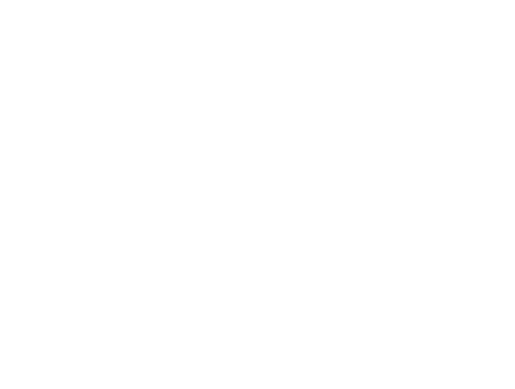

In [41]:
from pydrake.systems.pyplot_visualizer import PyPlotVisualizer
from pydrake.all import PiecewisePolynomial
from pydrake.geometry import MeshcatAnimation

visualizer = PyPlotVisualizer()
x0 = np.array(
        [-1.42628695e-01, 7.91008947e-01, -1.42999388e-01,
          -7.89749727e-01, 1.31650877e+00, -2.43590062e-01, 1.04394874e+00, 
          0, 0, 0, 
          0, 0, 0, 0]
      )
xflip = np.array(
          [-1.42628695e-01, 7.91008947e-01, -1.42999388e-01,
         -2.43590062e-01, 1.04394874e+00,  -7.89749727e-01, 1.31650877e+00, 
          0, 0, 0, 
          0, 0, 0, 0]
)

file_name = "planar_walker.urdf"
builder = DiagramBuilder()
scene_graph = builder.AddSystem(SceneGraph())
plant = MultibodyPlant(0.0)
plant.RegisterAsSourceForSceneGraph(scene_graph)
Parser(plant=plant).AddModels(file_name)

plant.WeldFrames(
            plant.world_frame(),
            plant.GetBodyByName("base").body_frame(),
            RigidTransform.Identity()
        )

plant.Finalize()
plant_context = plant.CreateDefaultContext()
plant.SetPositionsAndVelocities(plant_context, x0.reshape(-1,1))

n_q = plant.num_positions()
n_v = plant.num_velocities()
n_u = plant.num_actuators()


traj00 = np.vstack(
                    [x0.reshape(-1,14),
                    xflip.reshape(-1,14),
                    x0.reshape(-1,14),
                    xflip.reshape(-1,14),
                    x0.reshape(-1,14),
                    xflip.reshape(-1,14),
                    ]
                    )
traj00[:, 0] = np.linspace(x0[0], 3, 6)

x_traj00 = PiecewisePolynomial.ZeroOrderHold([0, 1, 2, 3, 4, 5], 
                                   traj00.T
                                           )
x_traj_source = builder.AddSystem(TrajectorySource(x_traj00))

demux = builder.AddSystem(Demultiplexer(np.array([n_q, n_v])))
to_pose = builder.AddSystem(MultibodyPositionToGeometryPose(plant))

builder.Connect(x_traj_source.get_output_port(), demux.get_input_port())
builder.Connect(demux.get_output_port(0), to_pose.get_input_port())
builder.Connect(to_pose.get_output_port(), scene_graph.get_source_pose_port(plant.get_source_id()))


MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)


diagram = builder.Build()
diagram.set_name("diagram")

ani = MeshcatAnimation()
simulator = Simulator(diagram)
simulator.Initialize()
simulator.set_target_realtime_rate(1)
simulator.AdvanceTo(5.3);
